## PHYS123 Group Homework Project

### Wolf Mermelstein, Sara Elanchezhian, Mathew Gummere
### December 2, 2023

# Part G1

Calculate and plot the recursively defined logistics function
$x_{n+1} = R x_n (1 - x_n)$.

We do this by creating a generator to yield logistics equation values, and then use it to find specific ranges of logistics equation values for given growth rates. For our samples we use 0.4 for $x_0$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterator

"""Generator that continuously yields logistics equation values at x_0 for some growth rate R."""
def compute_logistics_equation_values(R: float, x_0: float) -> Iterator[float]:
    x_prev = x_0
    while True:
        x_prev = R * x_prev * (1 - x_prev)
        yield x_prev
    

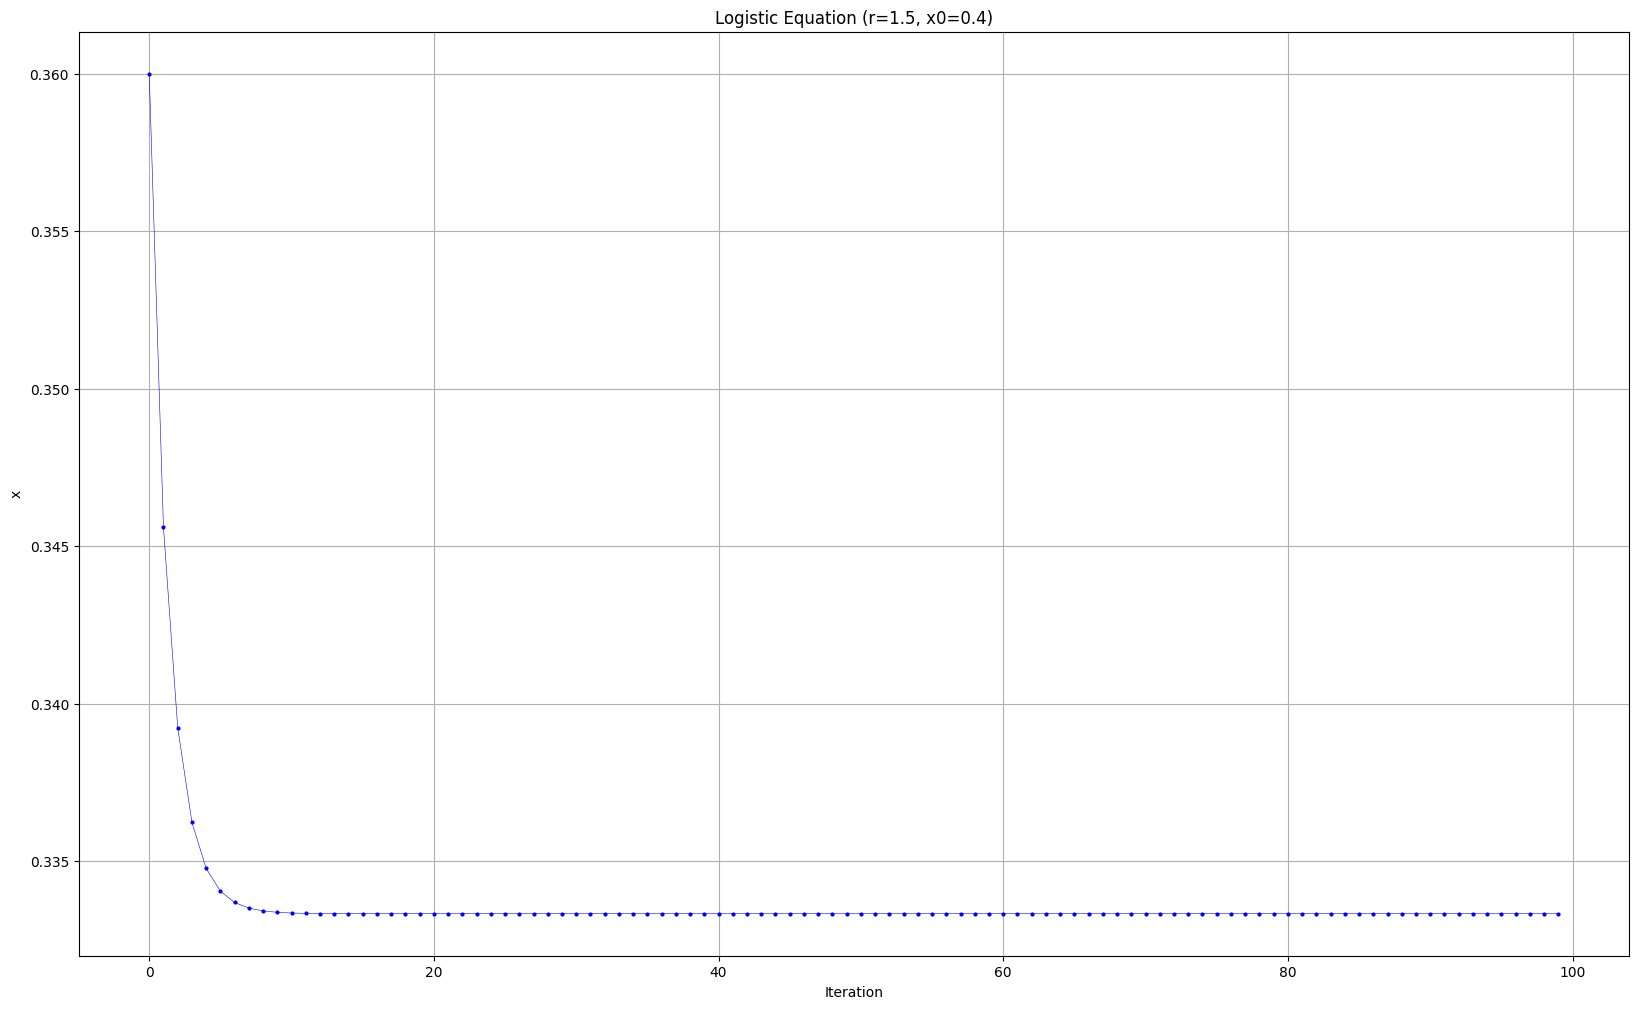

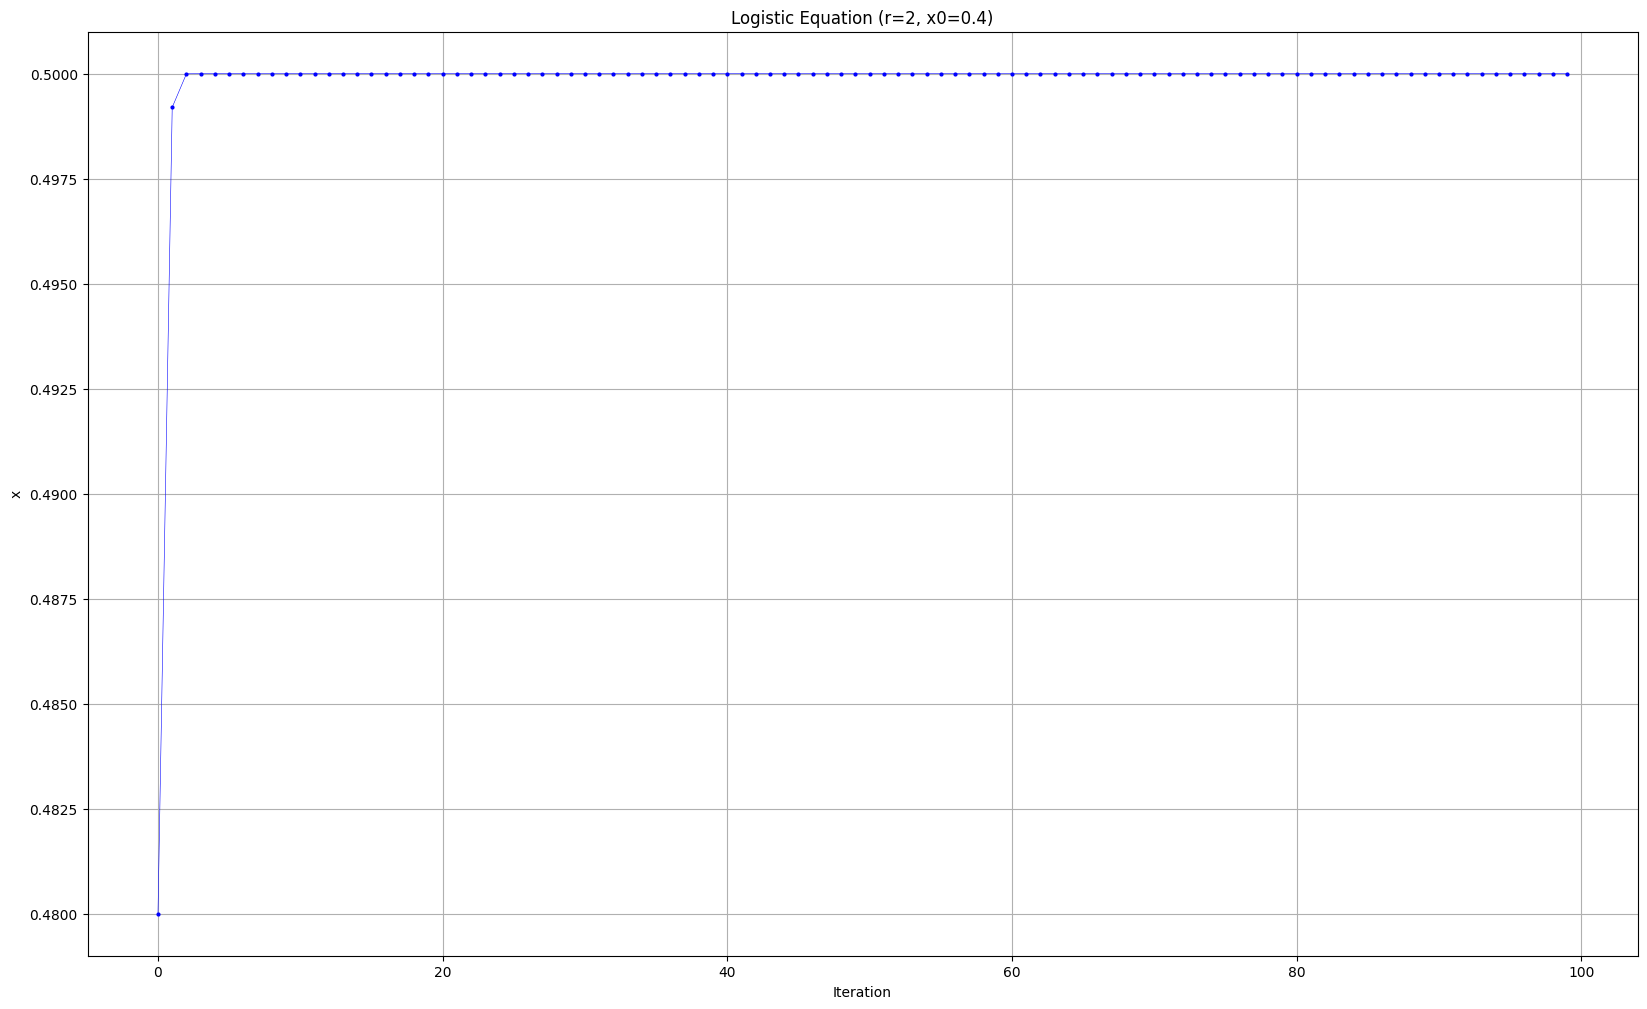

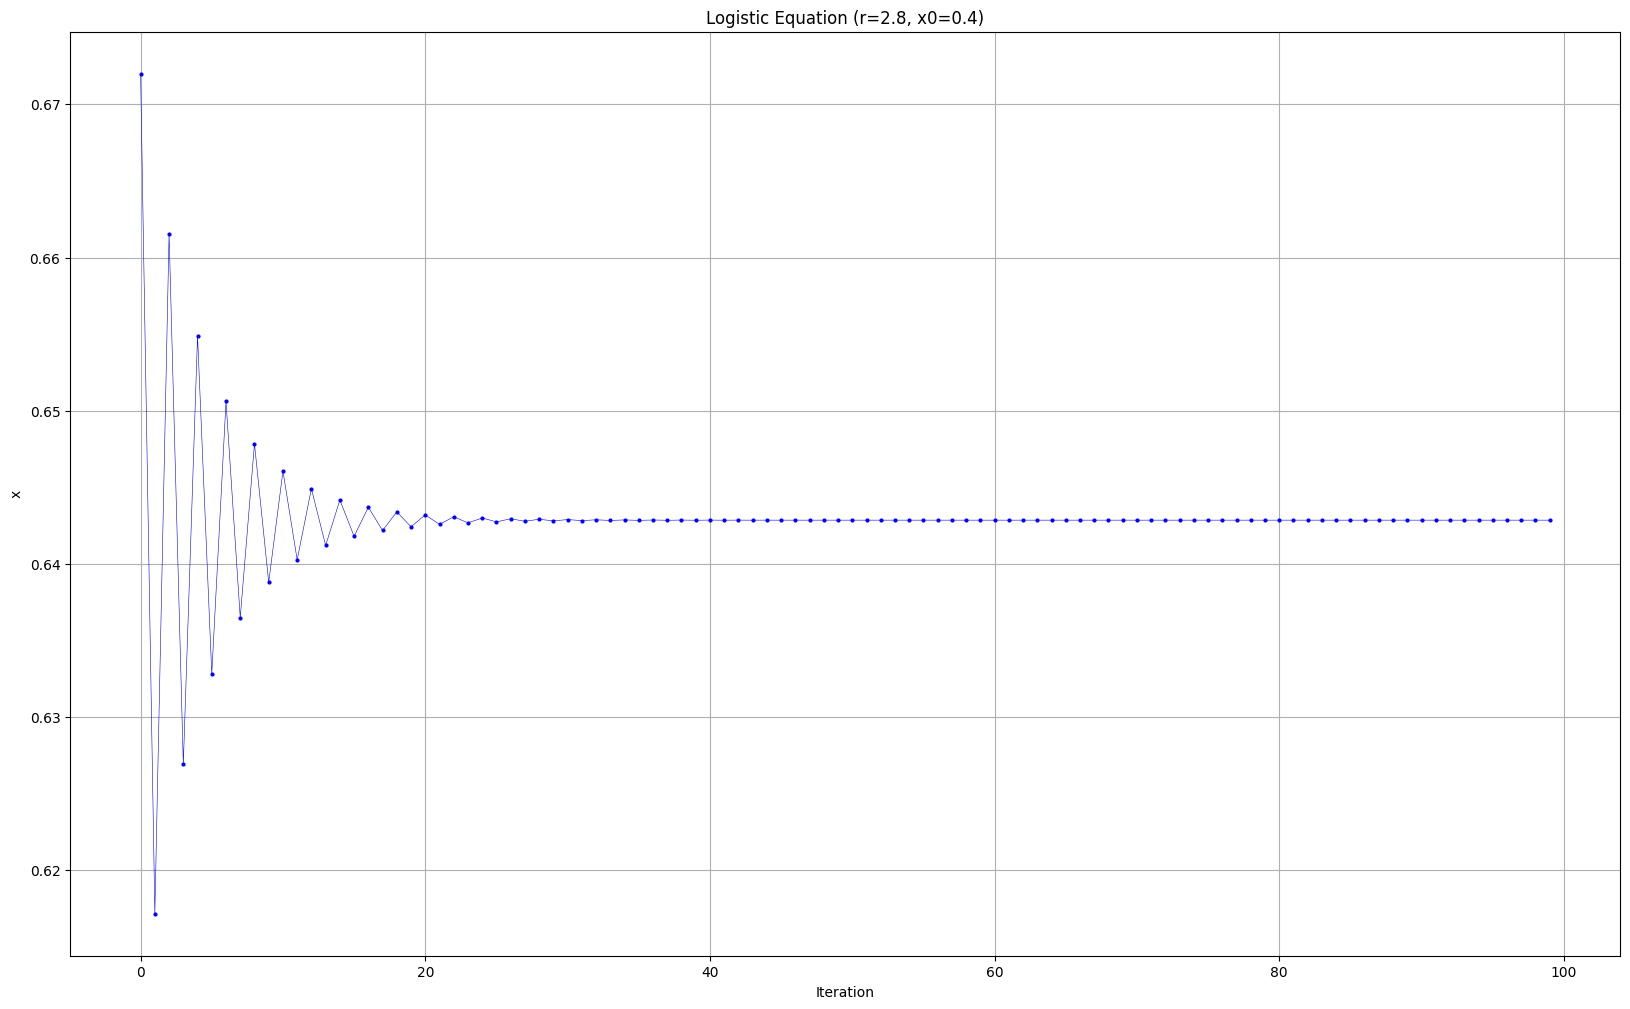

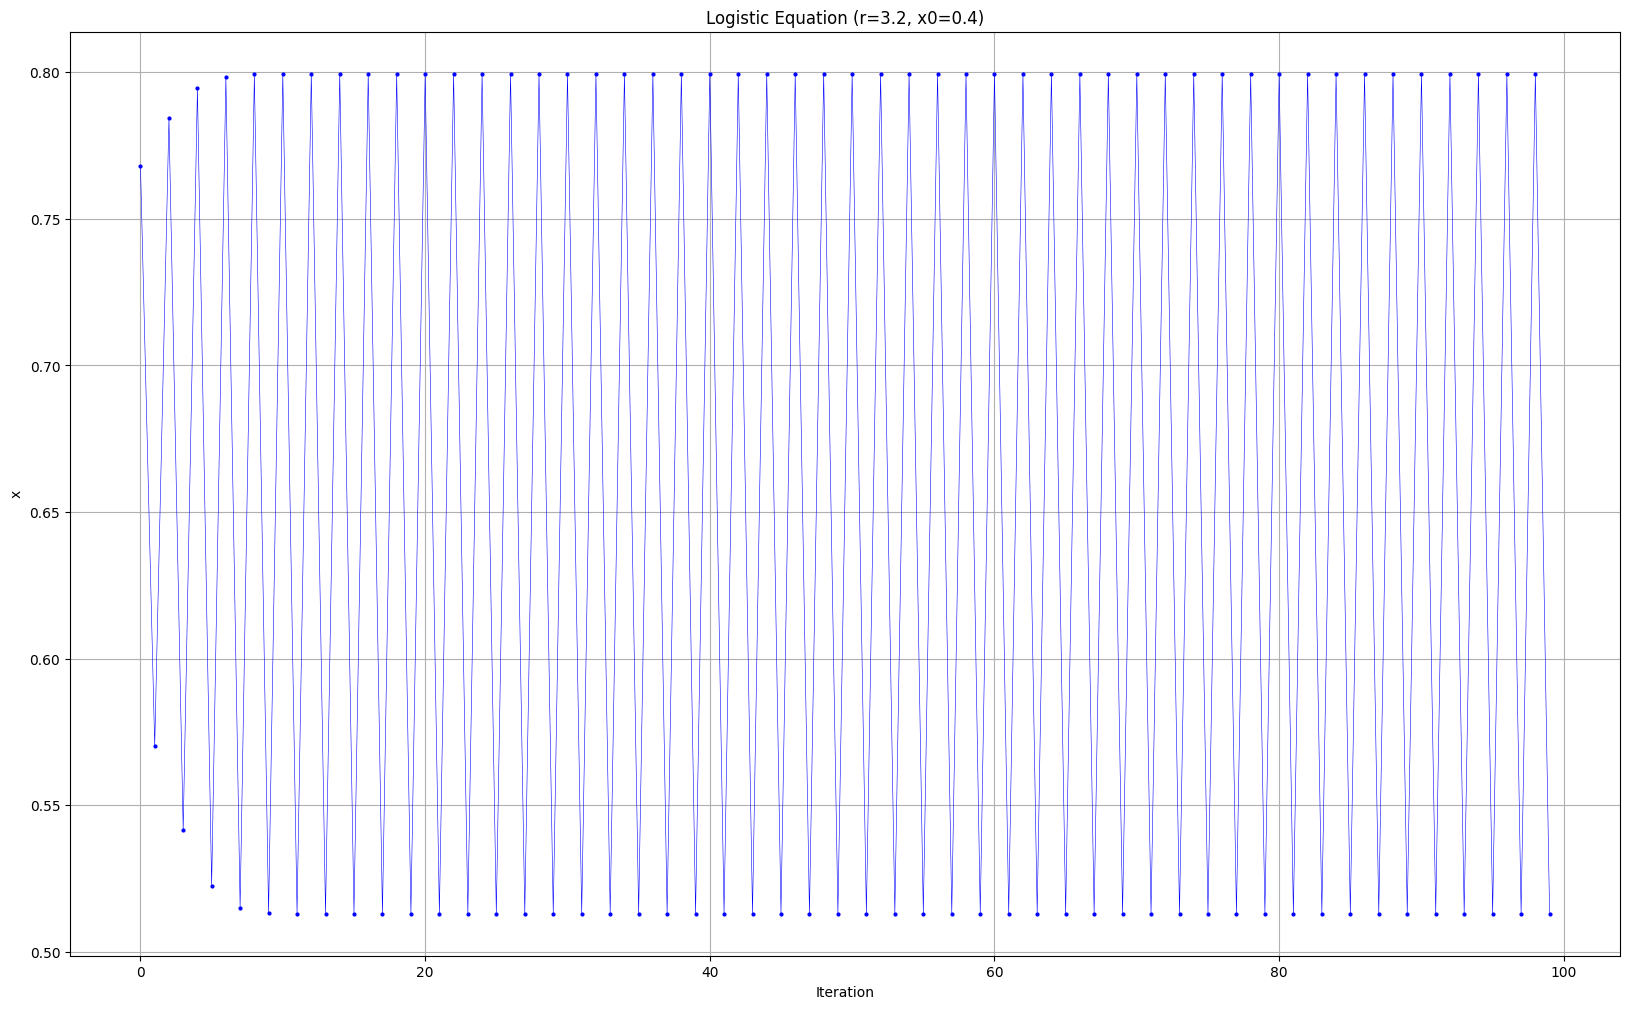

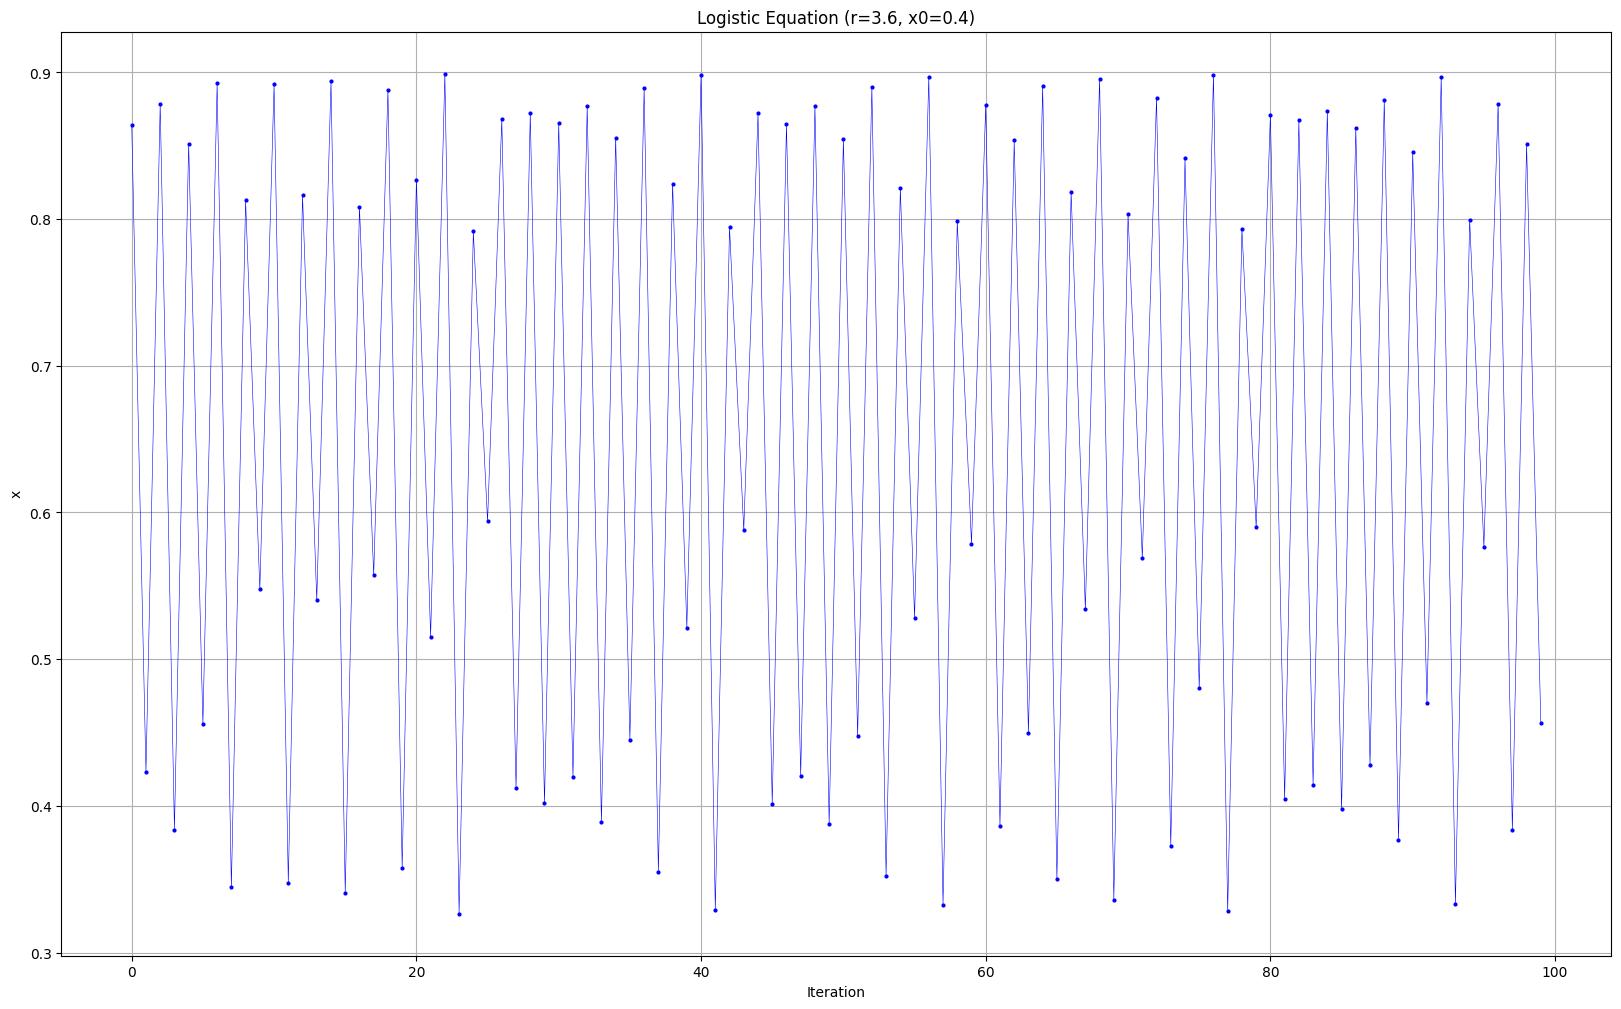

In [2]:
"""Plot the logistic equation values for some growth rate R and initial value x_0."""
def plot_logistic_equation(iteration_counts, x_values, R, x_0):
    fig, ax = plt.subplots(figsize=(20, 12))

    # Create a line plot of the iteration counts vs. the logistic equation values.
    ax.plot(iteration_counts, x_values, marker='o', linestyle='-', color='b', lw=.4, markersize=2)
    ax.set_title(f'Logistic Equation (r={R}, x0={x_0})')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('x')
    ax.grid(True)
    return ax
    
"""
Compute the coordinates for the logistic equation values for some growth rate R and 
initial value x_0.
"""
def compute_logistics_equation_coordinates(R: float, x_0: float, N: int) -> np.ndarray:
    # Compute values using the generator that we previously defined.
    x_values = np.fromiter(compute_logistics_equation_values(R, x_0), float, count=N)
    # Create an array of iteration counts.
    iteration_counts = np.arange(N)
    return iteration_counts, x_values
    
# Plot the logistic equation values for some growth rate R and initial value x_0.
scan_values = (1.5, 2, 2.8, 3.2, 3.6)
for R in scan_values:
    x_coords, y_coords = compute_logistics_equation_coordinates(R, 0.4, 100)
    plot_logistic_equation(
        x_coords, 
        y_coords, 
        R=R,
        x_0=0.4
    )
    
plt.show()

# Part G2

Finding values of $R_n$ where the logisics equation switches from

* Period 1 to period 2, $R_1$
* Period 2 to period 4, $R_2$
* Period 4 to period 8, $R_3$
* Period 8 to period 16, $R_4$
* Period 16 to period 32, $R_5$

## Computationally determining bifurcation points

### Determining equilibrium values

In order to determine the $R$ values for period switches, we first develop an algorithm to find the equilibrium values for a given $R$ value.

In [3]:
from decimal import Decimal

"""
Determine the equilibrium values for the logistic equation for some growth rate R and initial 
value x_0.

We do this by creating a buckets dictionary that maps each possible equilibrium value to the
number of times that value was seen. We then iterate over the generator and increment the
count for each equilibrium value that we see.

We maintain a set of equilibrium values that we have already seen many times, which have
crossed a threshold of being seen enough to be considered an equilibrium value. 
"""
def find_equilibrium_values(
    generator,
    R, 
    x_0,
    iterations_to_skip=5000,
    iterations_to_take=42000, 
    threshold_ceil=150,
    threshold_floor=50,
    max_possible_R=4,
    too_close_filter=0.0001
):
    generator = generator(R, x_0)
    for i in range(iterations_to_skip):
        next(generator)
                
    # Create an empty dictionary that maps equilibrium values to the number of times they 
    # were seen.
    start = Decimal('0')
    end = Decimal('1.00001')
    step = Decimal('0.00001')
    keys = [start + i * step for i in range(int((end - start) / step))]
    buckets = dict.fromkeys(keys, 0)
    equilibrium_values = set()
    
    threshold = threshold_ceil + (threshold_floor - threshold_ceil) * (max_possible_R - 1) / (4 - 1)
    for i in range(iterations_to_take):
        x = Decimal(next(generator)).quantize(step)
        if x in buckets:
            buckets[x] += 1
            if buckets[x] >= threshold:
                equilibrium_values.add(x)
            
    # Filter out all the values that are within 0.00005 of each other.
    filtered_equilibrium_values = set()
    for x in equilibrium_values:
        if not any(abs(x - y) < (too_close_filter) for y in filtered_equilibrium_values):
            filtered_equilibrium_values.add(x)
            
    return filtered_equilibrium_values
    

In [4]:
equilibrium_values = find_equilibrium_values(
    compute_logistics_equation_values,
    3.571, 
    0.4
)
print(equilibrium_values)
print(len(equilibrium_values))

equilibrium_values = find_equilibrium_values(
    compute_logistics_equation_values, 
    3.556,
    0.4
)
print(equilibrium_values)
print(len(equilibrium_values))

{Decimal('0.87822'), Decimal('0.89204'), Decimal('0.80351'), Decimal('0.89272'), Decimal('0.34403'), Decimal('0.80588'), Decimal('0.89009'), Decimal('0.34192'), Decimal('0.88044')}
9
{Decimal('0.35092'), Decimal('0.80997'), Decimal('0.88104'), Decimal('0.88899'), Decimal('0.83138'), Decimal('0.54733'), Decimal('0.37271'), Decimal('0.49849')}
8


## Determining bifurcation values

Now, repeating for increasing $R$ values, we the number of bifurcations for given $R$ values, and determine when the number of periods increase.

In [5]:
"""
Determine the R values that correspond to period switches by counting the number of equilibrium
values for each R value in an increasing range of R values. Then return the R values that
correspond to period switches.

Uses the find_equilibrium_values function that we previously defined.
"""
def find_period_switch_values(
    generator,
    min_val=1,
    max_val=4, 
    x_0=0.4,
    **kwargs
):
    # Create an array of R values from R_min to R_max
    scan_values = np.arange(min_val, max_val, 0.0001)
    
    # Find the R values that correspond to period switches. Whenever we find a period switch we
    # skip ahead 20 R values to avoid finding the same period switch multiple times.
    period_switch_values = set()
    last_period_switch_value = None
    equilibrium_values_counts = [
        len(
            find_equilibrium_values(
                generator,
                scan_values[0],
                x_0,
                **kwargs
            )
        )
    ]
    
    skip_amount = 50
    i = 1
    while i < len(scan_values):
        equilibrium_values_counts.append(
            len(
                find_equilibrium_values(
                    generator, 
                    scan_values[i], 
                    x_0,
                    **kwargs
                )
            )
        )
        
        if ((len(equilibrium_values_counts) > 1) 
            and (equilibrium_values_counts[-2] < equilibrium_values_counts[-1])):
            period_switch_values.add((scan_values[i] + scan_values[i - 1]) / 2)
            equilibrium_values_counts.clear()
            if i + skip_amount < len(scan_values):
                i += skip_amount
            else:
                break
        else:
            i += 1
            
    output_set = set()
    # Iterate through each value in the input set
    for value in period_switch_values:
        # Check if the value is not within the specified range of any other value
        if all(abs(value - other) > (0.001) for other in output_set):
            output_set.add(value)
        
    return period_switch_values


In [6]:
from queue import PriorityQueue

# From looking a plot we can find intervals with known period switches, so that we do not need
# to scan the entire range of R values 0 to 4.
known_period_switch_intervals = (
    (2.99, 3.01),
    (3.44, 3.46),
    (3.54, 3.55),
    (3.56, 3.57),
)

period_switch_values = PriorityQueue(maxsize=5)
for interval in known_period_switch_intervals:
    if not period_switch_values.full():
        for new_value in (map(lambda x: round(x, 8), 
                find_period_switch_values(
                    compute_logistics_equation_values, 
                    *interval
                ))):
            period_switch_values.put(new_value)
        print(list(period_switch_values.queue))
        
period_switch_values = list(period_switch_values.queue)

[2.99905]
[2.99905, 3.44925]
[2.99905, 3.44925, 3.54405]
[2.99905, 3.44925, 3.54405, 3.56965, 3.56435]


# Plotting a bifurcation diagram

Now that we've developed a way to computationally find the bifurcation points and determine the R values of bifurcation, we create a plot to visualize our findings.

In [7]:
"""
Generate bifurcation plot coordinates.

Arguments:
    equilibrium_value_generator: Generator that yields the equilibrium values given some R/G and x_0.
    value_count: Number of values to have for x axis.
    value_min: Initial value for x axis.
    value_max: Maximal value for x axis.
    iterations_to_start_at: Number of values to skip past for each x value.
    
Returns:
    The x and y coordinates.
"""
def compute_bifurcation_plot_coords(
        equilibrium_value_generator,
        value_count, 
        value_min, 
        value_max, 
        x_0=0.4,
        iterations_to_start_at=900, 
        x_per_value_count=100
    ):
    x_coords = np.zeros(value_count * x_per_value_count)
    y_coords = np.zeros(value_count * x_per_value_count)
    next_val = 0

    # For each R value in an evenly distributed range starting at <R_value_min> up to <R_value_max>
    # with R_value_count values overall.
    for x_type_val in np.linspace(value_min, value_max, value_count):
        # Create a generator to compute x values from
        generator = equilibrium_value_generator(x_type_val, x_0)
        
        # Skip past <iteration_to_start_at> number of computed x values
        for i in range(iterations_to_start_at):
            next(generator)
            
        # Generate <x_per_R_value_count> number of x values and add them to the plot at the current
        # R value (recall x axis is R)
        for i in range(x_per_value_count):
            x_coords[next_val] = x_type_val
            y_coords[next_val] = next(generator)
            next_val += 1

    return x_coords, y_coords

"""
Plot some x coordinates against y coordinates over a clipped region.

Args:
    x_coords: The x coords to plot.
    y_coords: The y coords to plot.
    title: The title of the plot.
    x_min: The minimum x cut off.
    x_max: The maximum x cut off.
    width: The width of the plot.
    height: The height of the plot.
    fontsize: The fontsize of the plot.
    dot_size: The size of the dots in the plot.
    highlighted_vertical_lines: The vertical lines to highlight.
"""
def plot_bifurcation_diagram(
    x_coords, 
    y_coords, 
    title="",
    x_min=None, 
    x_max=None, 
    width=50, 
    height=30,
    fontsize=24,
    dot_size=0.05,
    gridline_count=30,
    x_label="R",
    y_label="x_eq",
    highlight_vertical_lines=()
):
    # Create the plot
    fig, axes = plt.subplots(figsize=(width, height))

    # Clip the plot if we have a min or max provided
    if x_min or x_max:
        axes.set_xlim(x_min, x_max)

    # Plot the coordinates
    axes.scatter(x_coords, y_coords, marker='o', linestyle='-', color='b', s=dot_size)

    # Set the title and labels of the plot
    axes.set_title(f'{title} (from x={x_min} to x={x_max})', fontsize=fontsize)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    
    # Specify the positions of our vertical gridlines by disabling the default x axis gridlines
    # and then manually adding in our own.
    axes.grid(axis='y', linestyle='--')
    gridlines = np.linspace(*axes.get_xlim(), gridline_count).tolist()
    for gridline in gridlines:
        axes.axvline(x=gridline, color='black', linestyle='-', linewidth=.3)
        
    # Highlight the vertical lines that we want to highlight.
    for i, line in enumerate(highlight_vertical_lines):
        axes.axvline(x=line, color='red', linestyle='-', linewidth=.3)
        gridlines.append(i + 1)

    axes.set_xticks(gridlines)



In [8]:
# Compute the bifurcation plot coordinates
x_coords, y_coords = compute_bifurcation_plot_coords(
    compute_logistics_equation_values,
    10000, 
    2.5, 
    4,
)

# Create an alias to plot a slice of the bifurcation diagram.
def plot_bifurcation_diagram_slice(x_min=None, x_max=None):
    plot_bifurcation_diagram(
        x_coords, 
        y_coords, 
        "Bifurcation Diagram", 
        width=300, 
        height=62,
        dot_size=.01,
        gridline_count=0,
        x_min=x_min,
        x_max=x_max,
        highlight_vertical_lines=tuple(period_switch_values)
    )
    
# Plot the bifurcation diagram and a slice of its tail so that later bifurcations are more
# clearly visible.
plot_bifurcation_diagram_slice()
plot_bifurcation_diagram_slice(3.5, 3.8)
    
plt.show()

# Part G3

Repeat the exercise in HW G-2 but instead of using the logistics equation use the "laser" mapping $x_{n+1} = g x_n (1 - \tanh{(x_n)})$. Find the values of $G_n$ where the logistics equation switches from period 1 to period 2.

To achieve this we redefine a new generator, `compute_laser_equation_values`, to compute values, which we feed into the same x-y coordinate computing function, `compute_bifurcation_plot_coords`, that we defined earlier. We then plot various subsections to show period switches more clearly.



In [9]:
from numpy import tanh

"""Generator that continuously yields laser equation values at x_0 for some growth rate R."""
def compute_laser_equation_values(G: float, x_0: float) -> Iterator[float]:
    x_prev = x_0
    while True:
        x_prev = G * x_prev * (1 - tanh(x_prev))
        yield x_prev

In [10]:
# Find the period switch G values for the laser equation
period_switch_G_values = find_period_switch_values(
    compute_laser_equation_values,
    min_val=1,
    max_val=10, 
    x_0=0.4,
    iterations_to_skip=2000,
    iterations_to_take=42000, 
)

# Compute the bifurcation plot coordinates for the laser equation
x_coords, y_coords = compute_bifurcation_plot_coords(
    compute_laser_equation_values,
    70000, 
    1, 
    10,
)

# Plot the entire bifurcation diagram
plot_bifurcation_diagram(
    x_coords, 
    y_coords, 
    "Laser Bifurcation Diagram, all periods", 
    width=100, 
    height=40,
    x_min=1,
    x_max=10,
    dot_size=.015,
    x_label="G",
)

"""Plot a slice of the bifurcation diagram for the laser equation."""
def plot_laser_slice(x_min, x_max, title):
    plot_bifurcation_diagram(
        x_coords, 
        y_coords, 
        f"{title} Laser Bifurcation Diagram", 
        width=48, 
        height=26,
        x_min=x_min,
        x_max=x_max,
        dot_size=.04,
        x_label="G",
        highlight_vertical_lines=tuple(period_switch_G_values)
    )
    
# Plot slices of the bifurcation diagram for the laser equation for different period switches
plot_laser_slice(5, 5.2, "Laser Bifurcation Plot, Period 0-1")
plot_laser_slice(8, 8.2, "Laser Bifurcation Plot, Period 1-2")
plot_laser_slice(9, 9.15, "Laser Bifurcation Plot, Period 2-3")
plot_laser_slice(9.2, 9.38, "Laser Bifurcation Plot, Period 3-4-5")

# Part G5

Consider the logisics equation $x_{n+1} = R x_n (1 - x_n)$ with the growth parameter set to
$R = 3.6$. 

Define a sequence $x_{true}$ to be set of the $x_n$ calculated with $R = 3.6$ and $x_0 = 0.5$

Define a sequence $x_{pred}$ to be set of the $x_n$ calculated with $R = 3.6$ and $x_0 = 0.5 + \epsilon $. 

The idea is that even a small error $\epsilon$ in the initial conditon will lead to predicted values that vary wildly from the "true" values.

## Step 1: Finding equilibrium values
First we will use our previously defined `find_equilibrium_values` function to compute equilibrium values for the perfectly accurate system with $x_0 = 0.5$ and $R = 3.6$.

In [ ]:
"""Add an error to an x_0 value."""
def with_error(x_0, error):
    return x_0 + error

R = 3.6 # Growth rate
N = 200 # Number of iterations to take
x_0_original = 0.5  # Original x_0 value
x_0_departed_delta = 0.1  # Distance from x_0_original to consider it sufficiently departed
x_0_errors = [x_0_original/(10 ** i) for i in range(1, 9)]
x_0_with_errors = [with_error(x_0_original, error) for error in x_0_errors]

# Create containers to hold data that we will later plot
x_0_errors_values = {x_0_error: np.fromiter(
    compute_logistics_equation_values(R, x_0_error), 
    float, count=N
) for x_0_error in x_0_with_errors}
x_0_errors_departure_points = {x_0_error: 0 for x_0_error in x_0_with_errors}

# Find the equilibrium values for the logistic equation for some growth rate R and initial 
# value x_0.
true_equilibrium_values = find_equilibrium_values(
    compute_logistics_equation_values, 
    R,
    x_0_original,
    iterations_to_skip=5_000_000,
    iterations_to_take=1_500_000,
    threshold_floor=100,
    threshold_ceil=200,
    too_close_filter=0.005
)
true_equilibrium_values = [round(x, 5) for x in map(float, true_equilibrium_values)]
true_x_0_values =np.fromiter(compute_logistics_equation_values(R, x_0_original), float, count=N)
print(true_equilibrium_values)
print(len(true_equilibrium_values))
original_plot_axes = plot_logistic_equation(
    np.arange(1, N + 1, 1),
    true_x_0_values,
    R=R,
    x_0=x_0_original
)
# Add horizontal lines to the plot to indicate the equilibrium values
for equilibrium_value in true_equilibrium_values:
    original_plot_axes.axhline(y=equilibrium_value, color='red', linestyle='-', linewidth=.2)


# Then we iterate through alternative "errored" x_0 values, and generate x values using
# compute_logistics_equation_values for each of them. Using these generators we iterate until
# we are
for x_0_error in x_0_with_errors:
    departed = False
    for i, x_value in enumerate(compute_logistics_equation_values(3.6, x_0_error)):
        if i == N:
            break
        
        x_0_errors_values[x_0_error][i] = x_value
        
        if not departed and abs(x_value - true_x_0_values[i]) >= x_0_departed_delta:
            departed = True
            x_0_errors_departure_points[x_0_error] = float(i + 1)
        
# Create a list of the x_0 errors' respective departure points to highlight as vertical lines
# on the plot.
iterations_of_departure = tuple(x_0_errors_departure_points.values())

# G6
Now we will plot $x_0$ alongside all the values of $x_0$ containing errors.
This will let us determine when the values go astray and will showcase how finer accuracy by
10x only has a near-linear effect.

In [ ]:
"""Superpose an additional plot onto the main plot axes."""
def plot_y_axis(axes, x_values, y_values, color, label, width=.5, dot_size=.06):
    axes.scatter(x_values, y_values, color=color, label=label, linewidth=width, s=dot_size)
    axes.set_ylabel(label, color=color)
    
colors = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f')

# Create the plot
fig, axes = plt.subplots(figsize=(60, 10))
plt.title("Effect of x_0 errors on end behavior")

# Plot the original x_0 value, true_x_0_values
plot_y_axis(
    axes, 
    np.arange(1, N + 1, 1), 
    true_x_0_values, 
    'black', 
    f"x_0 = {x_0_original} (true x values)",
    dot_size=5,
    width=15
)

# Plot the x_0 values with errors
for i, x_0_error in enumerate(x_0_with_errors):
    plot_y_axis(
        axes, 
        np.arange(1, N + 1, 1),
        x_0_errors_values[x_0_error], 
        colors[i], 
        f"x_0 = {x_0_error} (error: {round(x_0_error - x_0_original, 5)})",
        dot_size=20
    )
    
# Highlight the vertical lines for the departure points
for i, R_value_of_departure in enumerate(iterations_of_departure):
    axes.axvline(x=R_value_of_departure, color=colors[i], linestyle='-', linewidth=1)
    
    # Add a label to the vertical line that is vertical text
    axes.text(
        R_value_of_departure + 1, 
        0.5, 
        f"Departure from x_0 @ {x_0_with_errors[i]}",
        color=colors[i],
        fontsize=12,
        rotation=90
    )
    
# Add a vertical line for every single iteration
for i in range(N):
    axes.axvline(x=i, color='black', linestyle='-', linewidth=.1)
    
# Add horizontal lines to the plot to indicate the equilibrium values
for equilibrium_value in true_equilibrium_values:
    axes.axhline(y=equilibrium_value, color='red', linestyle='--', linewidth=.1)
    
axes.set_xlabel("Iteration")
axes.legend(loc='upper right')
axes.grid(True)
axes.tick_params(axis='x', labelsize=5)
axes.tick_params(axis='y', labelsize=5)
plt.show()

## Plotting errors against iteration number

In [ ]:
from math import log

# Create a plot of errors against their respective departure points
fig, axes = plt.subplots(figsize=(10, 10))
plt.title("Effect of x_0 errors on end behavior")
axes.set_xlabel("x_0 error")
axes.set_ylabel("Departure point")
axes.scatter(x_0_with_errors, iterations_of_departure, color='black')
axes.grid(True)
plt.show()

# Create the same plot, but log the departure points
fig, axes = plt.subplots(figsize=(10, 10))
plt.title("Effect of x_0 errors on end behavior (-log_10 errors)")
axes.set_xlabel("x_0 error (-log_10)")
axes.set_ylabel("Departure point")

logged_x_0_errors = [-log(x_0_error, 10) for x_0_error in x_0_errors]
axes.scatter(logged_x_0_errors, iterations_of_departure, color='black')

# Add linear regression line
m, b = np.polyfit(logged_x_0_errors, iterations_of_departure, 1)
axes.plot(logged_x_0_errors, [m * x + b for x in logged_x_0_errors], color='red', linewidth=.5)

# Display the linear regression equation
axes.text(
    0.5, 
    0.5, 
    f"y = {round(m, 5)}x + {round(b, 5)}",
    color='red',
    fontsize=12,
    rotation=0
)

axes.grid(True)
plt.show()

# For fun: errors superposed on a bifurcation plot

In [ ]:

# Create the plot
fig, axes = plt.subplots(figsize=(40, 16))
plt.title("Effect of x_0 errors on bifurcations", fontsize=38)

# Create y axis for the various errors
errors = (0, 0.05, 0.005, 0.0005)

# Plot the data
for error, color in zip(errors, colors):
    x_coords, y_coords = x_coords, y_coords = compute_bifurcation_plot_coords(
        compute_logistics_equation_values,
        13000, 
        2.5, 
        4,
        x_0=with_error(0.4, error),
    )
    label = f'Error = {error}'
    plot_y_axis(axes, x_coords, y_coords, color=color, label=label)
    
# Add a legend
axes.legend(loc='upper left', fontsize=28, markerscale=80)
axes.grid(True)
axes.set_xlabel('R')
axes.set_ylabel('x_eq')
axes.set_xlim(2.6, 4)

# Show the plot
plt.show()